In [130]:
from pitas import power, flipper_tools
from orphics import maps as omaps
from pixell import enplot, enmap, curvedsky,powspec, enplot
import numpy as np
from cosmikyu import stats, mpi, datasets, config, utils
from itertools import product
import healpy as hp
import matplotlib.pyplot as plt
import random
from scipy.ndimage.filters import gaussian_filter1d


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
enmap.rand_gauss_harm??

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [150]:
_, cov = powspec.read_camb_scalar("/mnt/exos/dwhan89/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_scalCls.dat")
cov = cov[...,:10000+1]
l = np.arange(cov.shape[-1])
cov *= (l*(l+1))**2/(4)
#clpp = cov[0][0]
#l = np.arange(len(clpp))
clkk = cov[0][0]#(l*(l+1))**2/(4)*clpp

shape = (1,128, 128)
_, wcs = omaps.rect_geometry(width_arcmin=64, px_res_arcmin=0.5)
MG = omaps.MapGen(shape, wcs, cov)
data = np.array(MG.get_map())


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dwhan89/workspace/pixell/pixell/fft.py:177: DeprecationWarning: This function is deprecated in favour of``empty_aligned``.
  return engines[engine].n_byte_align_empty(shape, alignment, dtype)
/home/dwhan89/workspace/pixell/pixell/fft.py:177: DeprecationWarning: This function is deprecated in favour of``empty_aligned``.
  return engines[engine].n_byte_align_empty(shape, alignment, dtype)


In [115]:
cov.ndim

3

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dwhan89/workspace/pixell/pixell/fft.py:177: DeprecationWarning: This function is deprecated in favour of``empty_aligned``.
  return engines[engine].n_byte_align_empty(shape, alignment, dtype)


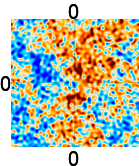

[1.14102305e-07 2.11202729e-08 1.23661851e-08 6.63364473e-09
 2.08640414e-09 3.32063371e-09 2.10582272e-09 1.50784871e-09
 1.37435400e-09 9.12708989e-10 8.01303519e-10 8.99197977e-10
 5.80713068e-10 5.47460262e-10 5.18806545e-10 5.30334211e-10
 4.04242462e-10 4.55008003e-10 3.72078628e-10 3.50322430e-10
 4.11551298e-10 2.93377770e-10 2.79494197e-10 2.64968543e-10
 2.13796972e-10 2.02641137e-10 2.01735378e-10 1.82637863e-10
 1.79286136e-10]


/home/dwhan89/workspace/pixell/pixell/fft.py:177: DeprecationWarning: This function is deprecated in favour of``empty_aligned``.
  return engines[engine].n_byte_align_empty(shape, alignment, dtype)


(0.0, 10000.0)

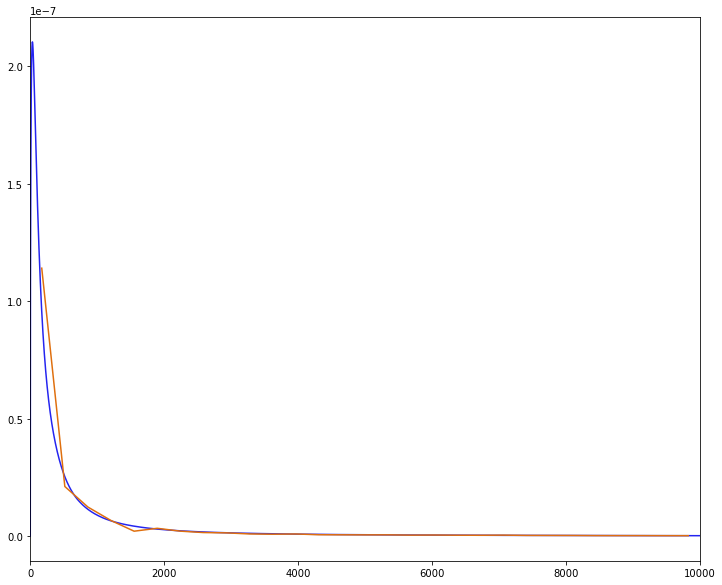

In [142]:
emap = MG.get_map()
enplot.pshow(emap)
lbin, clkk_bin = omaps.binned_power(emap, bin_edges=np.linspace(0,10000,30))
print(clkk_bin)
fig = plt.figure(figsize=(12,10))
plt.plot(l, clkk)
plt.plot(lbin, clkk_bin)
#plt.yscale("log")
plt.xlim(0, 10000)
#plt.ylim(1e-10, 5e-7)

In [120]:
class MapGen(object):
        """
        Once you know the shape and wcs of an ndmap and the input power spectra, you can 
        pre-calculate some things to speed up random map generation.
        """

        def __init__(self,shape,wcs,cov=None,covsqrt=None,pixel_units=False,smooth="auto",ndown=None,order=1):
                self.shape = shape
                self.wcs = wcs
                assert cov.ndim>=3 , "Power spectra have to be of shape (ncomp,ncomp,lmax) or (ncomp,ncomp,Ny,Nx)."
                if covsqrt is not None:
                    self.covsqrt = covsqrt
                else:
                    if cov.ndim==4:
                            if not(pixel_units): cov = cov * np.prod(shape[-2:])/enmap.area(shape,wcs )
                            if ndown:
                                self.covsqrt = downsample_power(shape,wcs,cov,ndown,order,exp=0.5)
                            else:
                                self.covsqrt = enmap.multi_pow(cov, 0.5)
                    else:
                            self.covsqrt = enmap.spec2flat(shape, wcs, cov, 0.5, mode="constant",smooth=smooth)


        def get_map(self,seed=None,scalar=False,iau=True,real=False):
                if seed is not None: np.random.seed(seed)
                rand = enmap.fft(enmap.rand_gauss(self.shape, self.wcs)) if real else enmap.rand_gauss_harm(self.shape, self.wcs)
                data = enmap.map_mul(self.covsqrt, rand)
                kmap = enmap.ndmap(data, self.wcs)
                if scalar:
                        return enmap.ifft(kmap).real
                else:
                        return enmap.harm2map(kmap,iau=iau)


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
